In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np

import sklearn.model_selection
from sklearn.metrics import r2_score, accuracy_score
#from imodels import FIGSRegressor, FIGSClassifier
#from imodels.importance import RandomForestPlusRegressor

import openml
from ucimlrepo import fetch_ucirepo 

from figs_d import *
from fourierDistill import *
from binary_mapper import *

In [2]:
def traverse_paths(node):
    if node is None:
        return []

    paths = []
    vals = []

    def dfs(current, path, from_left=False):
        if current.left is None and current.right is None and not from_left:
            paths.append(path.copy())
            vals.append(current.value.item())
            return 
        
        if current.left:
            dfs(current.left, [], from_left=True)

        if current.right:
            path.append(current)
            dfs(current.right, path)

    dfs(node, [])

    return list(zip(paths, vals))

In [16]:
dataset = sklearn.datasets.fetch_california_housing(as_frame = True)
X = dataset["data"]
y = dataset["target"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

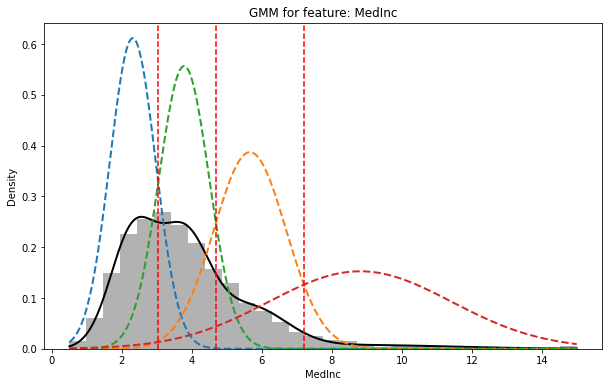

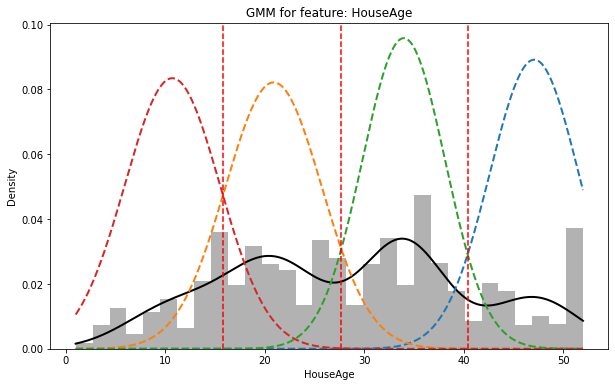

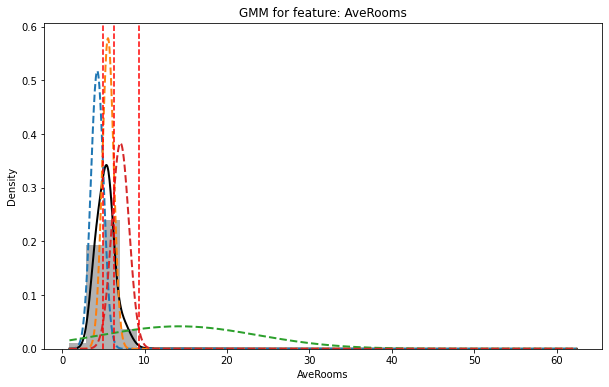

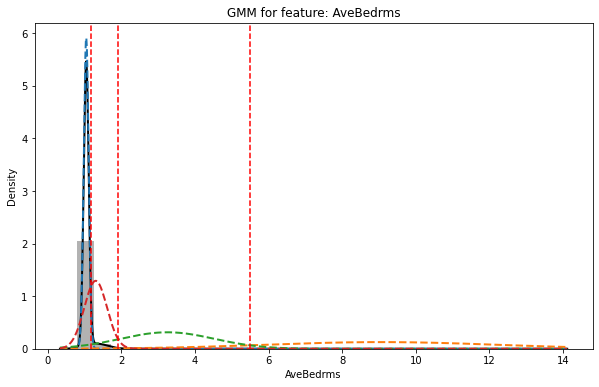

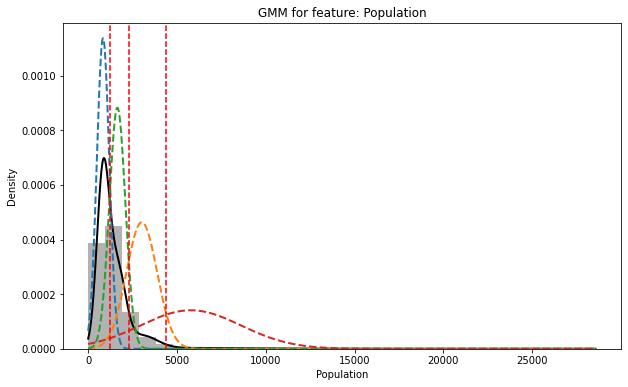

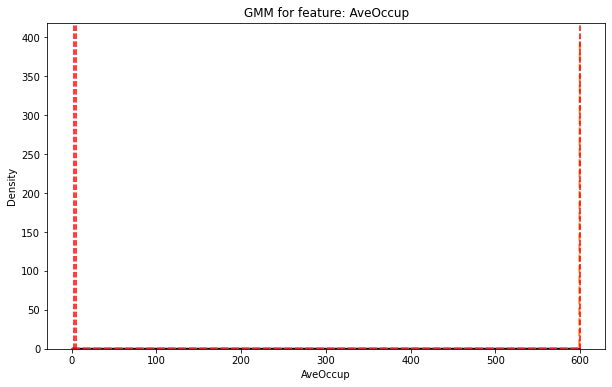

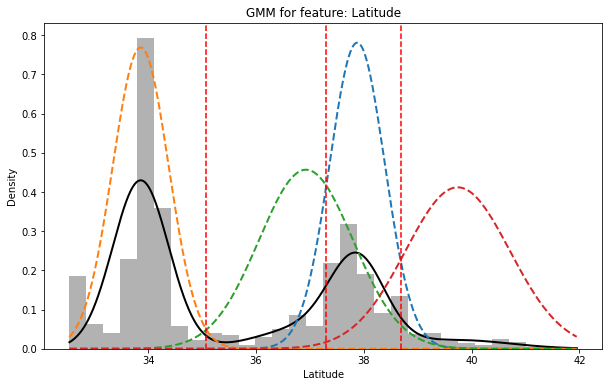

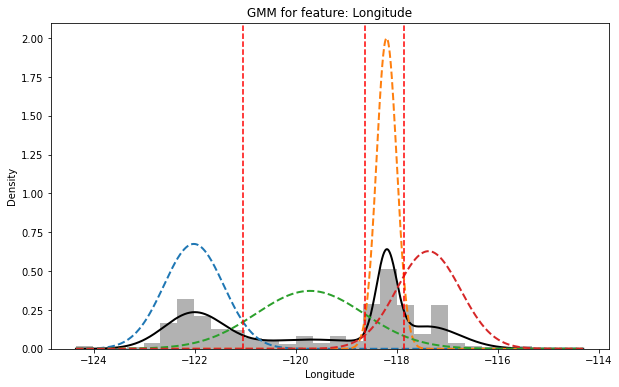

In [18]:
gmm_bm = GMMBinaryMapper()

#X_f, X_nf, y_f, y_nf = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

gmm_bm.fit(X_train, y_train, plot=True)

X_train_new = gmm_bm.transform(X_train)
X_val_new = gmm_bm.transform(X_val)

In [7]:
ftd = FTDistillRegressorCV(pre_interaction=None, post_max_features=10)
ftd.fit(X_train_new, y_train)

Index(['LATITUDE_region1', 'LATITUDE_region2', 'LATITUDE_region3',
       'LATITUDE_region4', 'LONGITUDE_region1', 'LONGITUDE_region2',
       'LONGITUDE_region3', 'LONGITUDE_region4', 'PARCELNO_region1',
       'PARCELNO_region2', 'PARCELNO_region3', 'PARCELNO_region4',
       'LND_SQFOOT_region1', 'LND_SQFOOT_region2', 'LND_SQFOOT_region3',
       'LND_SQFOOT_region4', 'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region2',
       'TOT_LVG_AREA_region3', 'TOT_LVG_AREA_region4', 'SPEC_FEAT_VAL_region1',
       'SPEC_FEAT_VAL_region2', 'SPEC_FEAT_VAL_region3',
       'SPEC_FEAT_VAL_region4', 'RAIL_DIST_region1', 'RAIL_DIST_region2',
       'RAIL_DIST_region3', 'RAIL_DIST_region4', 'OCEAN_DIST_region1',
       'OCEAN_DIST_region2', 'OCEAN_DIST_region3', 'OCEAN_DIST_region4',
       'WATER_DIST_region1', 'WATER_DIST_region2', 'WATER_DIST_region3',
       'WATER_DIST_region4', 'CNTR_DIST_region1', 'CNTR_DIST_region2',
       'CNTR_DIST_region3', 'CNTR_DIST_region4', 'SUBCNTR_DI_region1',
       '

In [62]:
figs = FIGSRegressor(max_rules = 17, max_trees = 10)
figs.fit(X_train_new, y_train, feature_names = list(X_train_new.columns))

FIGSRegressor(max_rules=17, max_trees=10)

In [114]:
len(figs.trees_)

5

In [70]:
figs_rules = [traverse_paths(t) for t in figs.trees_]

In [71]:
figs_rules

[[([TOT_LVG_AREA_region4 <= 0.500 (Tree #0 root)], 1091855.7534246575)],
 [([TOT_LVG_AREA_region4 <= 0.500 (split)], -443142.6554331287),
  ([SUBCNTR_DI_region1 <= 0.500 (split), OCEAN_DIST_region1 <= 0.500 (split)],
   180534.31971981787),
  ([SUBCNTR_DI_region1 <= 0.500 (split)], 346661.07328326924),
  ([CNTR_DIST_region1 <= 0.500 (split)], 774560.2698056045),
  ([structure_quality_5 <= 0.500 (Tree #1 root),
    OCEAN_DIST_region1 <= 0.500 (split),
    SPEC_FEAT_VAL_region1 <= 0.500 (split)],
   358546.01091775106)],
 [([TOT_LVG_AREA_region1 <= 0.500 (split)], -89750.2367261925),
  ([TOT_LVG_AREA_region3 <= 0.500 (Tree #2 root),
    LATITUDE_region3 <= 0.500 (split),
    SUBCNTR_DI_region1 <= 0.500 (split)],
   628521.2255317839)],
 [([PARCELNO_region2 <= 0.500 (split), HWY_DIST_region4 <= 0.500 (split)],
   568362.1081272357),
  ([structure_quality_2 <= 0.500 (Tree #3 root)], -49447.51132687579)],
 [([structure_quality_3 <= 0.500 (Tree #4 root)], 760738.8834760459)]]

In [72]:
figs_rules = [
    x
    for xs in figs_rules
    for x in xs
]

In [73]:
len(figs_rules)

11

In [74]:
paths = []
weights = []
for path, weight in figs_rules:
    cur_path = []
    for stop in path:
        cur_path.append(stop.feature_names[stop.feature])
    paths.append(tuple(cur_path))
    weights.append(weight)

In [86]:
'AJKD'.lower()

'ajkd'

In [94]:
figs_int = sorted(paths, key=lambda x: (len(x), x[0].lower()))

In [95]:
ftd_int = sorted(list(ftd.post_interaction_features), key=lambda x: (len(x), x[0].lower()))

In [96]:
figs_int

[('CNTR_DIST_region1',),
 ('structure_quality_2',),
 ('structure_quality_3',),
 ('SUBCNTR_DI_region1',),
 ('TOT_LVG_AREA_region1',),
 ('TOT_LVG_AREA_region4',),
 ('TOT_LVG_AREA_region4',),
 ('PARCELNO_region2', 'HWY_DIST_region4'),
 ('SUBCNTR_DI_region1', 'OCEAN_DIST_region1'),
 ('structure_quality_5', 'OCEAN_DIST_region1', 'SPEC_FEAT_VAL_region1'),
 ('TOT_LVG_AREA_region3', 'LATITUDE_region3', 'SUBCNTR_DI_region1')]

In [97]:
ftd_int

[('TOT_LVG_AREA_region1',),
 ('CNTR_DIST_region2', 'TOT_LVG_AREA_region3'),
 ('OCEAN_DIST_region1', 'SUBCNTR_DI_region1'),
 ('TOT_LVG_AREA_region4', 'structure_quality_4'),
 ('avno60plus_0', 'SPEC_FEAT_VAL_region3', 'CNTR_DIST_region1'),
 ('avno60plus_0', 'SPEC_FEAT_VAL_region4', 'CNTR_DIST_region1'),
 ('PARCELNO_region2', 'SUBCNTR_DI_region2', 'OCEAN_DIST_region1'),
 ('TOT_LVG_AREA_region4', 'avno60plus_0', 'structure_quality_5'),
 ('WATER_DIST_region1', 'structure_quality_5', 'OCEAN_DIST_region1')]

In [116]:
sum([x == y for x in figs_int for y in ftd_int])

1

In [98]:
flat_figs_int = [s for t in figs_int for s in t]
flat_ftd_int = [s for t in ftd_int for s in t]
print(f'FIGS unique: {sorted(list(set(flat_figs_int)))}')
print(f'FT Distill unique: {sorted(list(set(flat_ftd_int)))}')

FIGS unique: ['CNTR_DIST_region1', 'HWY_DIST_region4', 'LATITUDE_region3', 'OCEAN_DIST_region1', 'PARCELNO_region2', 'SPEC_FEAT_VAL_region1', 'SUBCNTR_DI_region1', 'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region3', 'TOT_LVG_AREA_region4', 'structure_quality_2', 'structure_quality_3', 'structure_quality_5']
FT Distill unique: ['CNTR_DIST_region1', 'CNTR_DIST_region2', 'OCEAN_DIST_region1', 'PARCELNO_region2', 'SPEC_FEAT_VAL_region3', 'SPEC_FEAT_VAL_region4', 'SUBCNTR_DI_region1', 'SUBCNTR_DI_region2', 'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region3', 'TOT_LVG_AREA_region4', 'WATER_DIST_region1', 'avno60plus_0', 'structure_quality_4', 'structure_quality_5']


In [99]:
from sklearn.metrics import r2_score

In [100]:
print(r2_score(y_val, ftd.predict(X_val_new)))
print(r2_score(y_val, figs.predict(X_val_new)))

0.6875009011481434
0.7423219195628676


In [101]:
print(r2_score(y_train, ftd.predict(X_train_new)))
print(r2_score(y_train, figs.predict(X_train_new)))

0.7354711268413527
0.7727836067711338


In [21]:
len(sorted(list(set(flat_figs_int))))

11

In [22]:
len(sorted(list(set(flat_ftd_int))))

15

In [81]:
len(list(set(flat_figs_int + flat_ftd_int)))

20

In [111]:
set(flat_figs_int) - set.intersection(set(flat_figs_int), set(flat_ftd_int))

{'HWY_DIST_region4',
 'LATITUDE_region3',
 'SPEC_FEAT_VAL_region1',
 'structure_quality_2',
 'structure_quality_3'}

In [110]:
'CNTR_DIST_region2',
 'SPEC_FEAT_VAL_region3',
 'SPEC_FEAT_VAL_region4',
 'SUBCNTR_DI_region2',
 'WATER_DIST_region1',
 'avno60plus_0',
 'structure_quality_4'

15

In [113]:
len(set(flat_figs_int))

13

In [118]:
set.intersection(set(flat_figs_int), set(flat_ftd_int))

{'CNTR_DIST_region1',
 'OCEAN_DIST_region1',
 'PARCELNO_region2',
 'SUBCNTR_DI_region1',
 'TOT_LVG_AREA_region1',
 'TOT_LVG_AREA_region3',
 'TOT_LVG_AREA_region4',
 'structure_quality_5'}